Results for Neural Network Regressor:
{'Model': 'Neural Network Regressor', 'Train R2': 0.8951347574310676, 'Train RMSE': 17.241046239079047, 'Train MSE': 297.2536754180618, 'Train MAE': 12.573719664211831, 'Test R2': 0.8946369493193838, 'Test RMSE': 17.415412579968738, 'Test MSE': 303.29659533053336, 'Test MAE': 12.71321360018371, 'Train Size': 52558, 'Test Size': 22525}


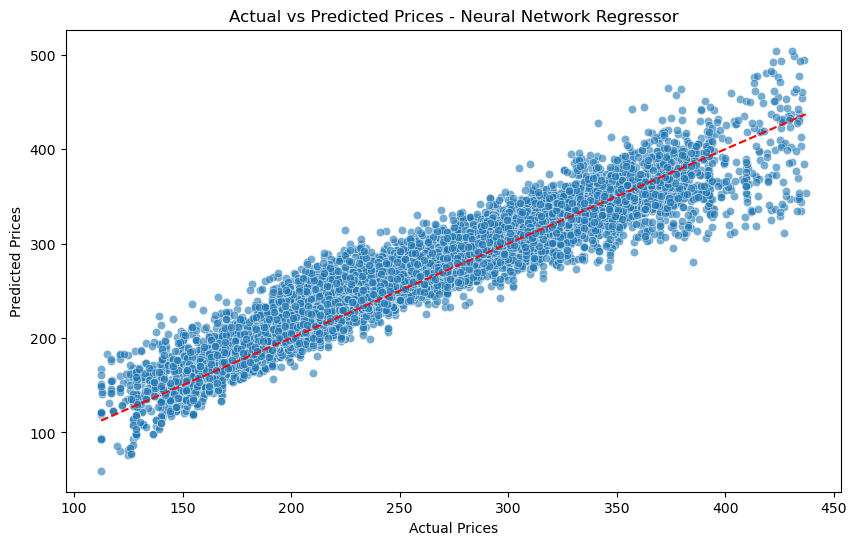

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df1 = pd.read_csv('./0507_cleaned_booking_hotels.csv')
df2 = pd.read_csv('./2506_cleaned_booking_hotels.csv')
df3 = pd.read_csv('./20_06_hotels_data_cleaned.csv')

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

# Function to fill NaN values with the mean of the group
def fill_na_with_group_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col].fillna(df[col].mean(), inplace=True)
    return df

# Fill NaN values for the entire dataset
df = fill_na_with_group_mean(df)

# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['price_per_night'])
    y = df['price_per_night']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Initialize Neural Network Regressor
    model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test)
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()


Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.p

Results for Neural Network Regressor:
{'Model': 'Neural Network Regressor', 'Train R2': 0.9726210568474569, 'Train RMSE': 8.809599675722984, 'Train MSE': 77.60904644649851, 'Train MAE': 5.403764063491257, 'Test R2': 0.9730775909684556, 'Test RMSE': 8.803321410996892, 'Test MSE': 77.4984678653163, 'Test MAE': 5.414021655129503, 'Train Size': 52558, 'Test Size': 22525, 'Best Parameters': {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}}


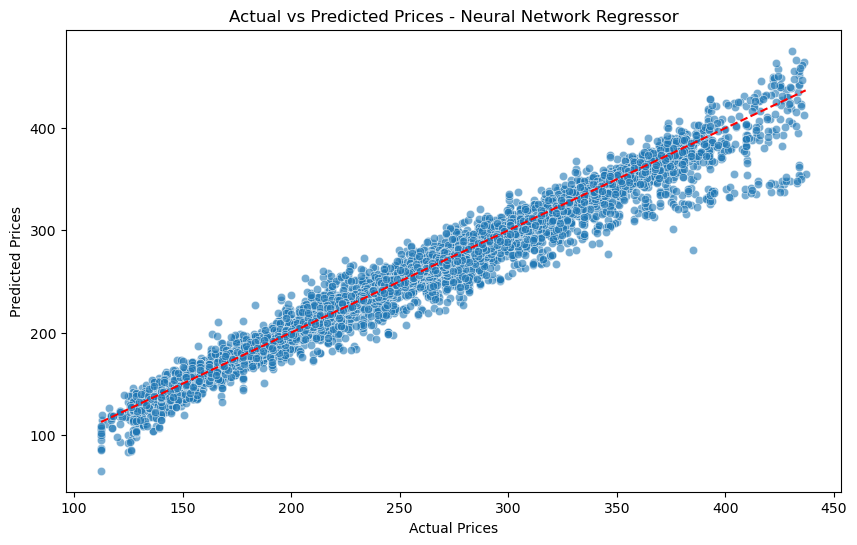

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df1 = pd.read_csv('./0507_cleaned_booking_hotels.csv')
df2 = pd.read_csv('./2506_cleaned_booking_hotels.csv')
df3 = pd.read_csv('./20_06_hotels_data_cleaned.csv')

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

# Function to fill NaN values with the mean of the group
def fill_na_with_group_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col].fillna(df[col].mean(), inplace=True)
    return df

# Fill NaN values for the entire dataset
df = fill_na_with_group_mean(df)

# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['price_per_night'])
    y = df['price_per_night']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()
